In [1]:
import os
from timeit import default_timer as timer
import numpy as np
import scipy.linalg as la
import theano as th
import theano.tensor as tt
import matplotlib.pyplot as plt
from dgm import model_wrappers, mnist
import hmc.constrained, hmc.unconstrained
from choldate import cholupdate
%matplotlib inline

## Set up experiment directories

In [2]:
base_dir = os.path.dirname(os.getcwd())
exp_dir = os.path.join(base_dir, 'results', 'mnist-inpainting')
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
model_dir = os.path.join(base_dir, 'models', 'mnist-vae-decoder')

In [3]:
logger = utils.setup_logger(exp_dir)

## Define generators constants

Generator takes a dict of fixed parameters / constants specifying behaviour as second argument.

In [4]:
consts = {
    'seed': 1234,
    'n_latent': 50,
    'n_pixel': 784,
    'output_std': 0.05,
    'observed_slice': slice(0, 28 * 7),
    'n_observed': 28 * 7
}

Load MNIST VAE decoder model parameters from file and use to define layers in generator `consts` dict.

In [5]:
with np.load(os.path.join(model_dir, 'params.npz')) as f:
    consts['mnist_vae_decoder_layers'] = [
        {'nonlinearity': tt.nnet.softplus, 
         'weights': tt.constant(f['weights_0'].T, 'W0', 2, th.config.floatX),
         'biases': tt.constant(f['biases_0'], 'b0', 1, th.config.floatX)},
        {'nonlinearity': tt.nnet.softplus, 
         'weights': tt.constant(f['weights_1'].T, 'W1', 2, th.config.floatX),
         'biases': tt.constant(f['biases_1'], 'b1', 1, th.config.floatX)},
        {'nonlinearity': tt.nnet.sigmoid, 
         'weights': tt.constant(f['weights_2'].T, 'W2', 2, th.config.floatX),
         'biases': tt.constant(f['biases_2'], 'b2', 1, th.config.floatX)},
    ]

Define seeded random number generator.

In [6]:
rng = np.random.RandomState(consts['seed'])

## Set up model

Generator Jacobian $\frac{\partial \boldsymbol{G}_y}{\partial \boldsymbol{u}} = \boldsymbol{J}$ can be partioned into a dense block $\boldsymbol{M}$ and diagonal block $\boldsymbol{D}$ i.e. $\boldsymbol{J} = \left[ \boldsymbol{M} ~ \boldsymbol{D} \right]$ due to independent Gaussian noise at output of generator. The Jacobian Gram matrix $\boldsymbol{J} \boldsymbol{J}^{\rm T}$ can therefore be decomposed as the sum of the products $\boldsymbol{M}\boldsymbol{M}^{\rm T}$ and $\boldsymbol{D}\boldsymbol{D}^{\rm T}$. As the number of columns of $\boldsymbol{M}$ (50, the VAE latent space dimension) is less than the number of rows (196, the number of observed pixels), the Cholesky decomposition of $\boldsymbol{D}\boldsymbol{D}^{\rm T} + \boldsymbol{M}\boldsymbol{M}^{\rm T}$ can be efficiently computed by doing low-rank Cholesky updates of $\boldsymbol{D}$ by the columns of $\boldsymbol{M}$.

In [7]:
def calc_gram_chol(jac):
    gram_chol = jac[:, -jac.shape[0]:] * 1.
    for col in jac[:, :-jac.shape[0]].T:
        cholupdate(gram_chol, col.copy())
    return gram_chol, False

Compile model wrapper object. This takes a Theano graph based generator definition and compiles the function needed by the constrained HMC sampler to perform inference.

In [8]:
model = model_wrappers.MinimalDifferentiableGenerativeModel(
    generator=mnist.mnist_region_generator,
    constants=consts,
    calc_gram_chol=calc_gram_chol
)

2017-03-09 18:55:11 dgm.model_wrappers:INFO Compiling generator function...
2017-03-09 18:55:12 dgm.model_wrappers:INFO ... finished in 1.8s
2017-03-09 18:55:12 dgm.model_wrappers:INFO Compiling generator Jacobian...
2017-03-09 18:55:13 dgm.model_wrappers:INFO ... finished in 0.3s
2017-03-09 18:55:13 dgm.model_wrappers:INFO Compiling energy gradient...
2017-03-09 18:55:13 dgm.model_wrappers:INFO ... finished in 0.5s
2017-03-09 18:55:13 dgm.model_wrappers:INFO Compiling base energy function...
2017-03-09 18:55:13 dgm.model_wrappers:INFO ... finished in 0.0s


Also compile a batch generator function for visualising samples.

In [9]:
u = tt.matrix('u')
x = mnist.mnist_generator(u, consts)
generator = th.function([u], x)

Define helper function for visualising image samples.

In [10]:
def plot_tiled_samples(xs, n_col=10, fig_size=(6, 6)):
    n_row = int(xs.shape[0] * 1. / n_col)
    tiled = np.empty((28 * n_row , 28 * n_col))
    for i, x in enumerate(xs):
        c = (i % n_col) * 28
        r = (i // n_col) * 28
        tiled[r:r+28, c:c+28] = x.reshape((28, 28))
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.imshow(tiled, cmap='gray', interpolation='None', vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    return fig, ax

## Observed data

Load observed image region to condition on.

In [11]:
with np.load(os.path.join(model_dir, 'observed.npz')) as f:
    y_obs = f['y_obs']

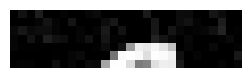

In [12]:
fig = plt.figure(figsize=(3, 1))
ax = fig.add_subplot(111)
ax.imshow(y_obs.reshape((7, 28)), cmap='gray', interpolation='None', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
fig.set_frameon(False)

## Constrained HMC

Set up geodesic integrator based constrained HMC sampler using compiled model functions and define sampler settings.

In [13]:
constr_sampler = hmc.constrained.LfGbabConstrainedIsotropicHmcSampler(
    energy_func=model.energy_func,
    constr_func=lambda u: model.generator_func(u) - y_obs,
    energy_grad=model.energy_grad,
    constr_jacob=model.constr_jacob,
    prng=rng,
    tol=1e-8,
    max_iters=100,
    n_inner_update=3
)
dt = 0.25
n_step_per_sample = (4, 6)
n_sample = 30
n_warm_up = 10
n_run = 1
rng.seed(consts['seed'])

Run sampling and visualise computed samples as grids of images.

2017-03-09 18:55:14 root:INFO Starting run 1...
2017-03-09 18:56:09 root:INFO ...completed, accepted: 0.9, run time: 55.0s


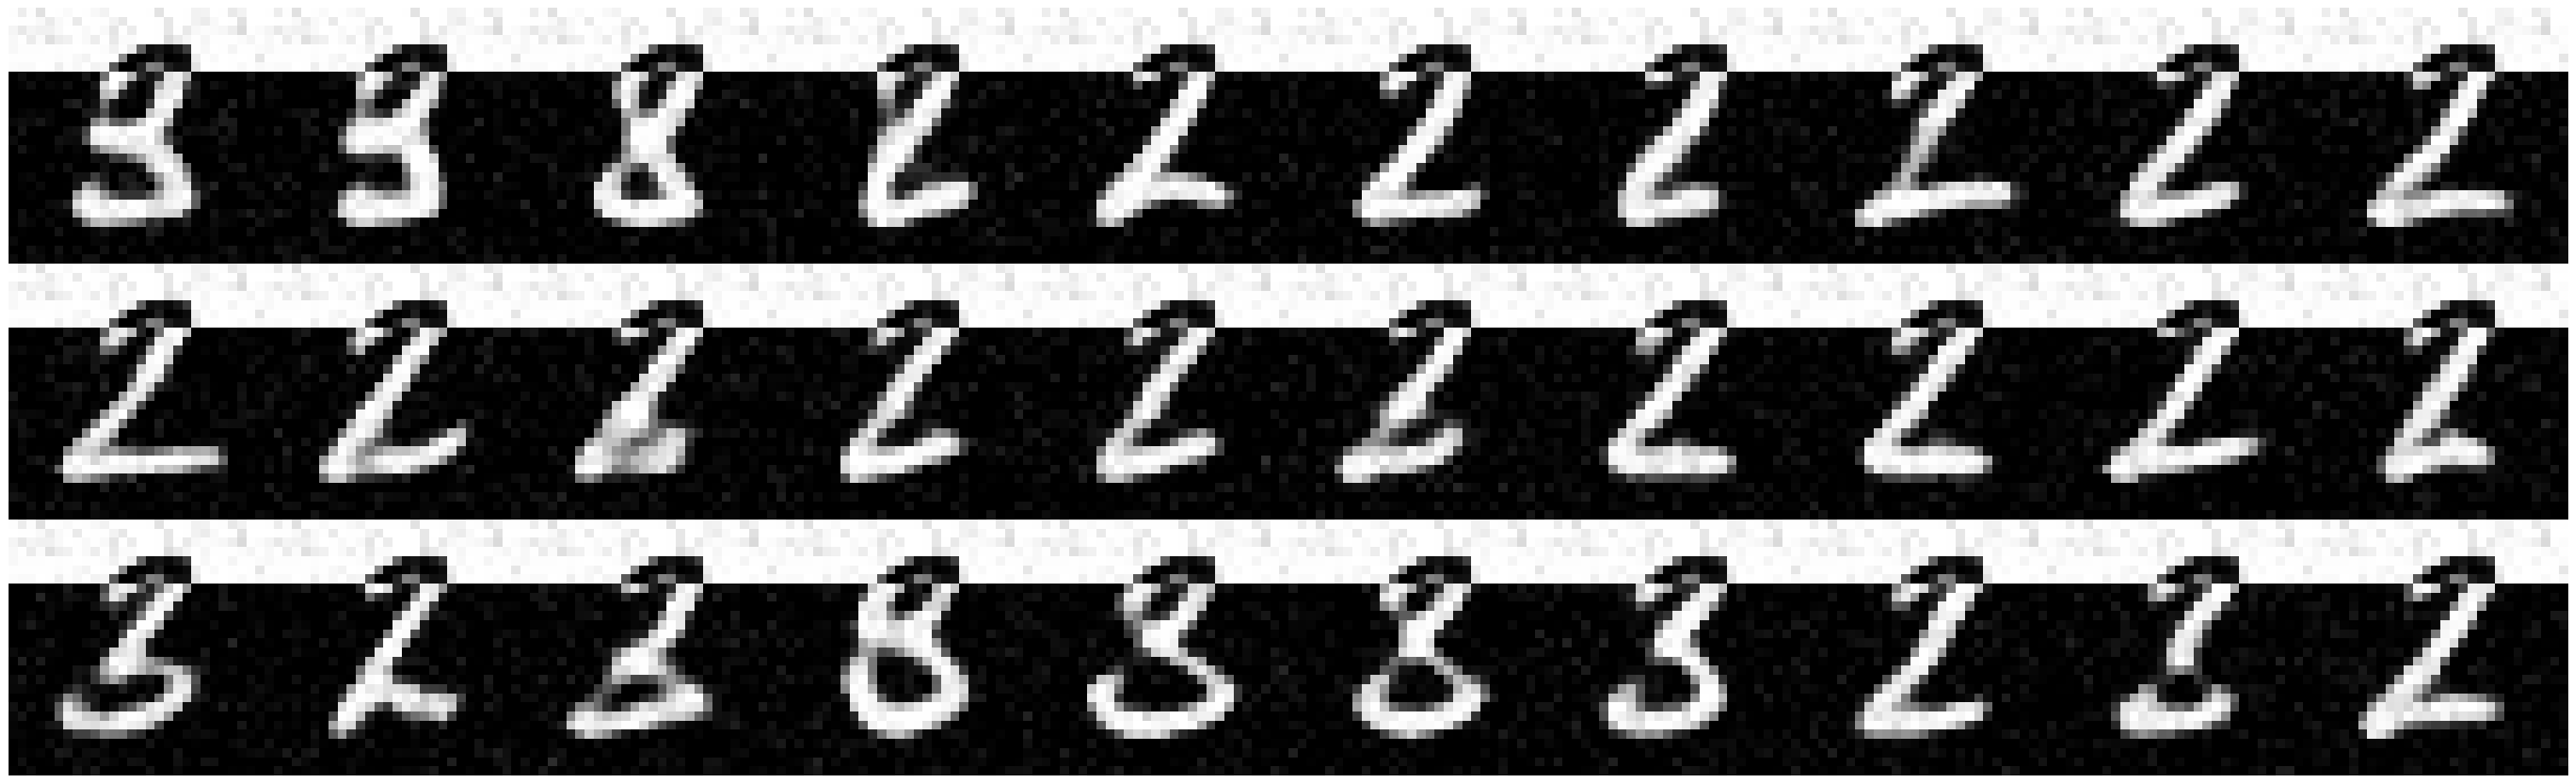

In [14]:
for r in range(n_run):
    try:
        u_init = np.zeros(consts['n_latent'] + consts['n_observed'])
        y_init = model.generator_func(u_init)
        u_init[-consts['n_observed']:] = (y_obs - y_init) / consts['output_std']
        assert np.allclose(model.generator_func(u_init), y_obs)
        logger.info('Starting run {0}...'.format(r+1))
        start_time = timer()
        u_samples, p_samples, accept = constr_sampler.get_samples(
            pos=u_init.copy(), dt=dt, 
            n_step_per_sample=n_step_per_sample, 
            n_sample=n_sample + n_warm_up
        )
        run_time = timer() - start_time
        logger.info('...completed, accepted: {0}, run time: {1:.1f}s'
                    .format(accept, run_time))
        x_samples = generator(np.c_[
                u_samples, 
                rng.normal(size=(u_samples.shape[0], 
                                 consts['n_pixel'] - consts['n_observed']))
        ])
        x_rev_samples = x_samples[n_warm_up:] * 1.
        x_rev_samples[:, consts['observed_slice']] = (
            1. - x_rev_samples[:, consts['observed_slice']])
        fig, ax = plot_tiled_samples(x_rev_samples, fig_size=(10, 3))
        ax.set_frame_on(False)
        fig.subplots_adjust(left=0, right=10., bottom=0, top=3.)
        fig.savefig(os.path.join(exp_dir, 'chmc-mnist-samples-{0}.png'.format(r+1)), 
                    bbox_inches='tight', pad_inches=0., dpi=28)
        plt.show()
        np.savez(os.path.join(exp_dir, 'chmc-results-{0}.npz'.format(r+1)),
            u_samples=u_samples, accept=accept, run_time=run_time, dt=dt, 
            x_samples=x_samples)
    except Exception as e:
        logger.exception('Error encountered run {0}:'.format(r+1))

## HMC in hierarchical model

As the joint density on generated outputs $\mathbf{x} = \left[\mathbf{y};\,\mathbf{z}\right]$ ($\mathbf{y}$ observed pixels, $\mathbf{z}$ unobserved pixels) and VAE decoder hidden representation $\mathbf{h}$ has a known hierarchical Gaussian density

$$
  \mathbb{p}\left[ \mathbf{x}=\boldsymbol{x},\,\mathbf{h}=\boldsymbol{h} \right] =
  \mathcal{N}\left( \boldsymbol{x} \,|\, \boldsymbol{\mu}(\boldsymbol{h}),\,\sigma^2 \boldsymbol{I} \right)
  \mathcal{N}\left( \boldsymbol{h} \,|\, \boldsymbol{0},\, \boldsymbol{I} \right)
$$

we can also try running standard HMC in the conditional density $\mathbb{p}\left[ \mathbf{z}=\boldsymbol{z},\,\mathbf{h}=\boldsymbol{h} \,|\, \mathbf{y}=\boldsymbol{y} \ \right]$ which is proportional to the above joint density.

The energy (negative logarith of the unnormalised density) corresponding to this model can be define in Theano as below.

In [15]:
h = tt.vector('h')
y_mean = mnist.mnist_vae_decoder(h, consts['mnist_vae_decoder_layers'])
energy_hier = (
    0.5 * ((y_obs - y_mean[consts['observed_slice']])**2 / 
           consts['output_std']**2).sum() + 
    0.5 * h.dot(h)
)
energy_hier_func = th.function([h], energy_hier)
energy_hier_grad = th.function([h], tt.grad(energy_hier, h))

Set up the unconstrained HMC sampler with the compiled energy function / gradient and define sampler settings.

In [16]:
hier_hmc_sampler = hmc.unconstrained.IsotropicHmcSampler(
    lambda u, cache={}: energy_hier_func(u), 
    lambda u, cache={}: energy_hier_grad(u),
    rng)
n_step_per_sample = (30, 50)
n_run = 1
n_warm_up = 20
n_sample = 1200
thin_factor = 40
dt = 15e-3
u_init = np.zeros(consts['n_latent'])
rng.seed(consts['seed'])

Run sampling and visualise computed samples as grids of images.

2017-03-09 18:56:10 root:INFO Starting run 1...
2017-03-09 18:57:09 root:INFO ...completed, accepted: 0.690983606557, run time: 59.1s


Consecutive samples


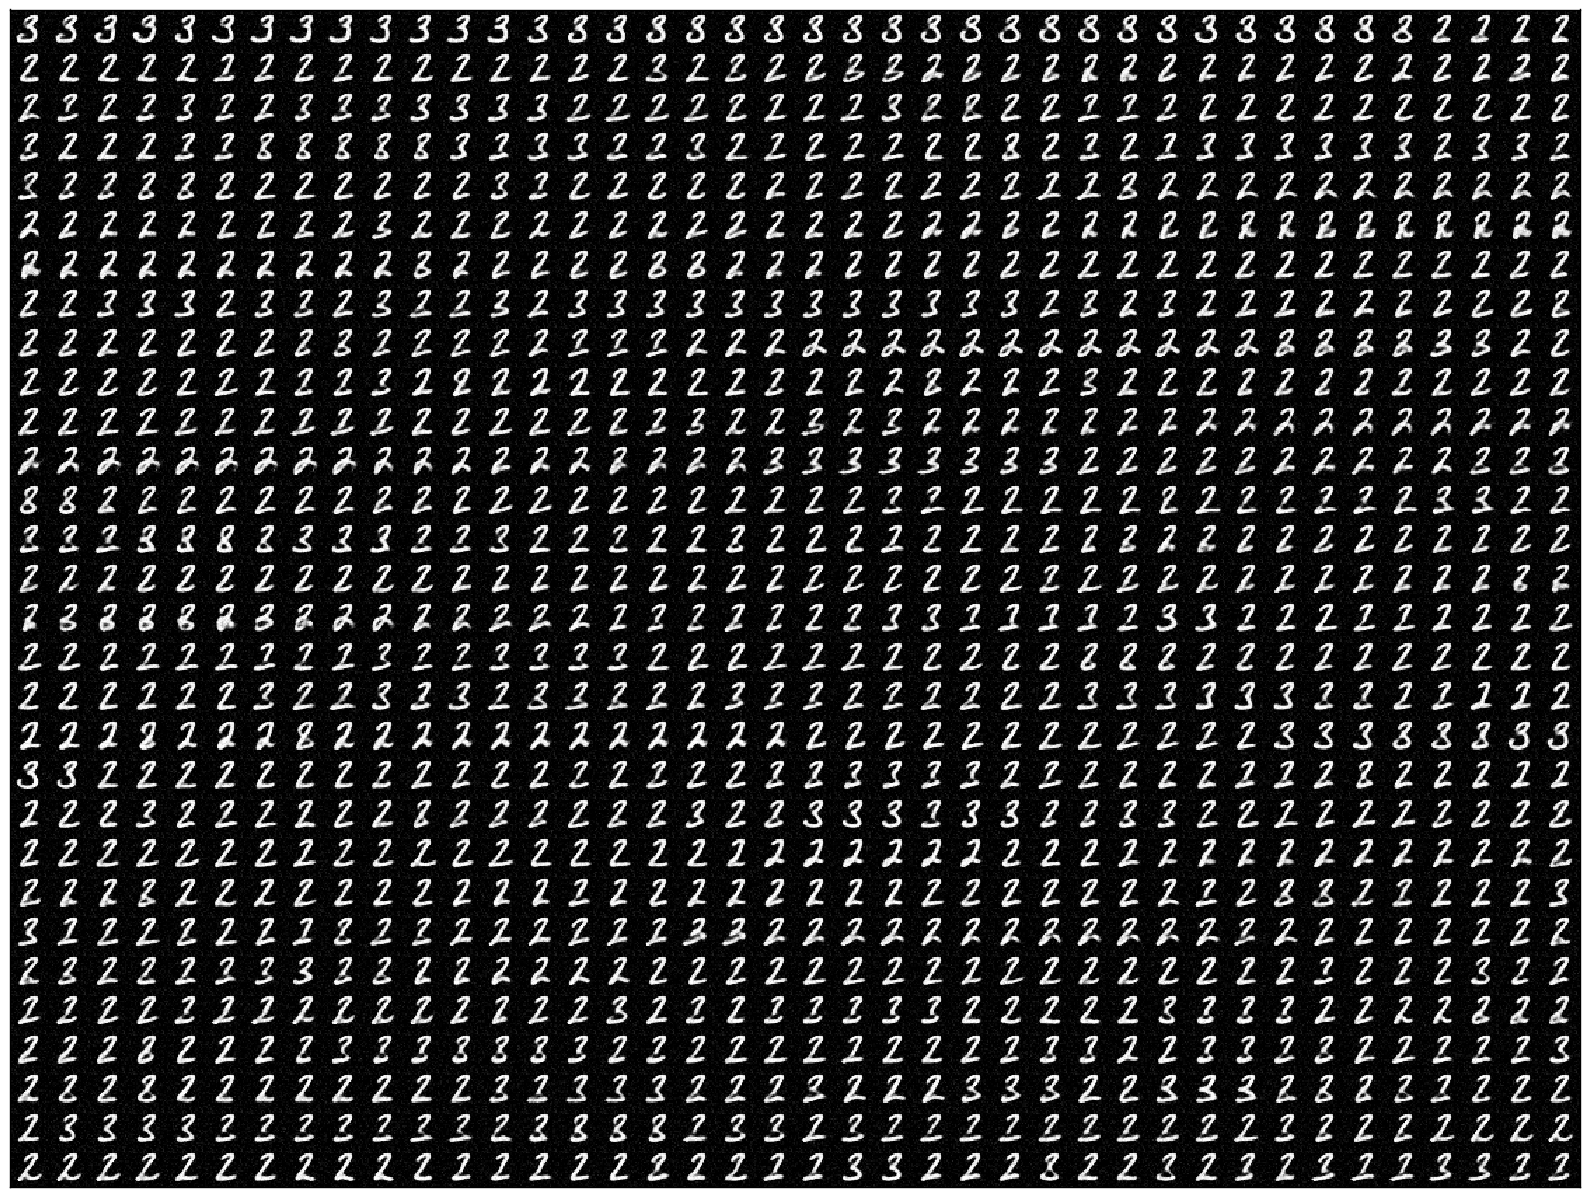

Samples thinned by factor 40


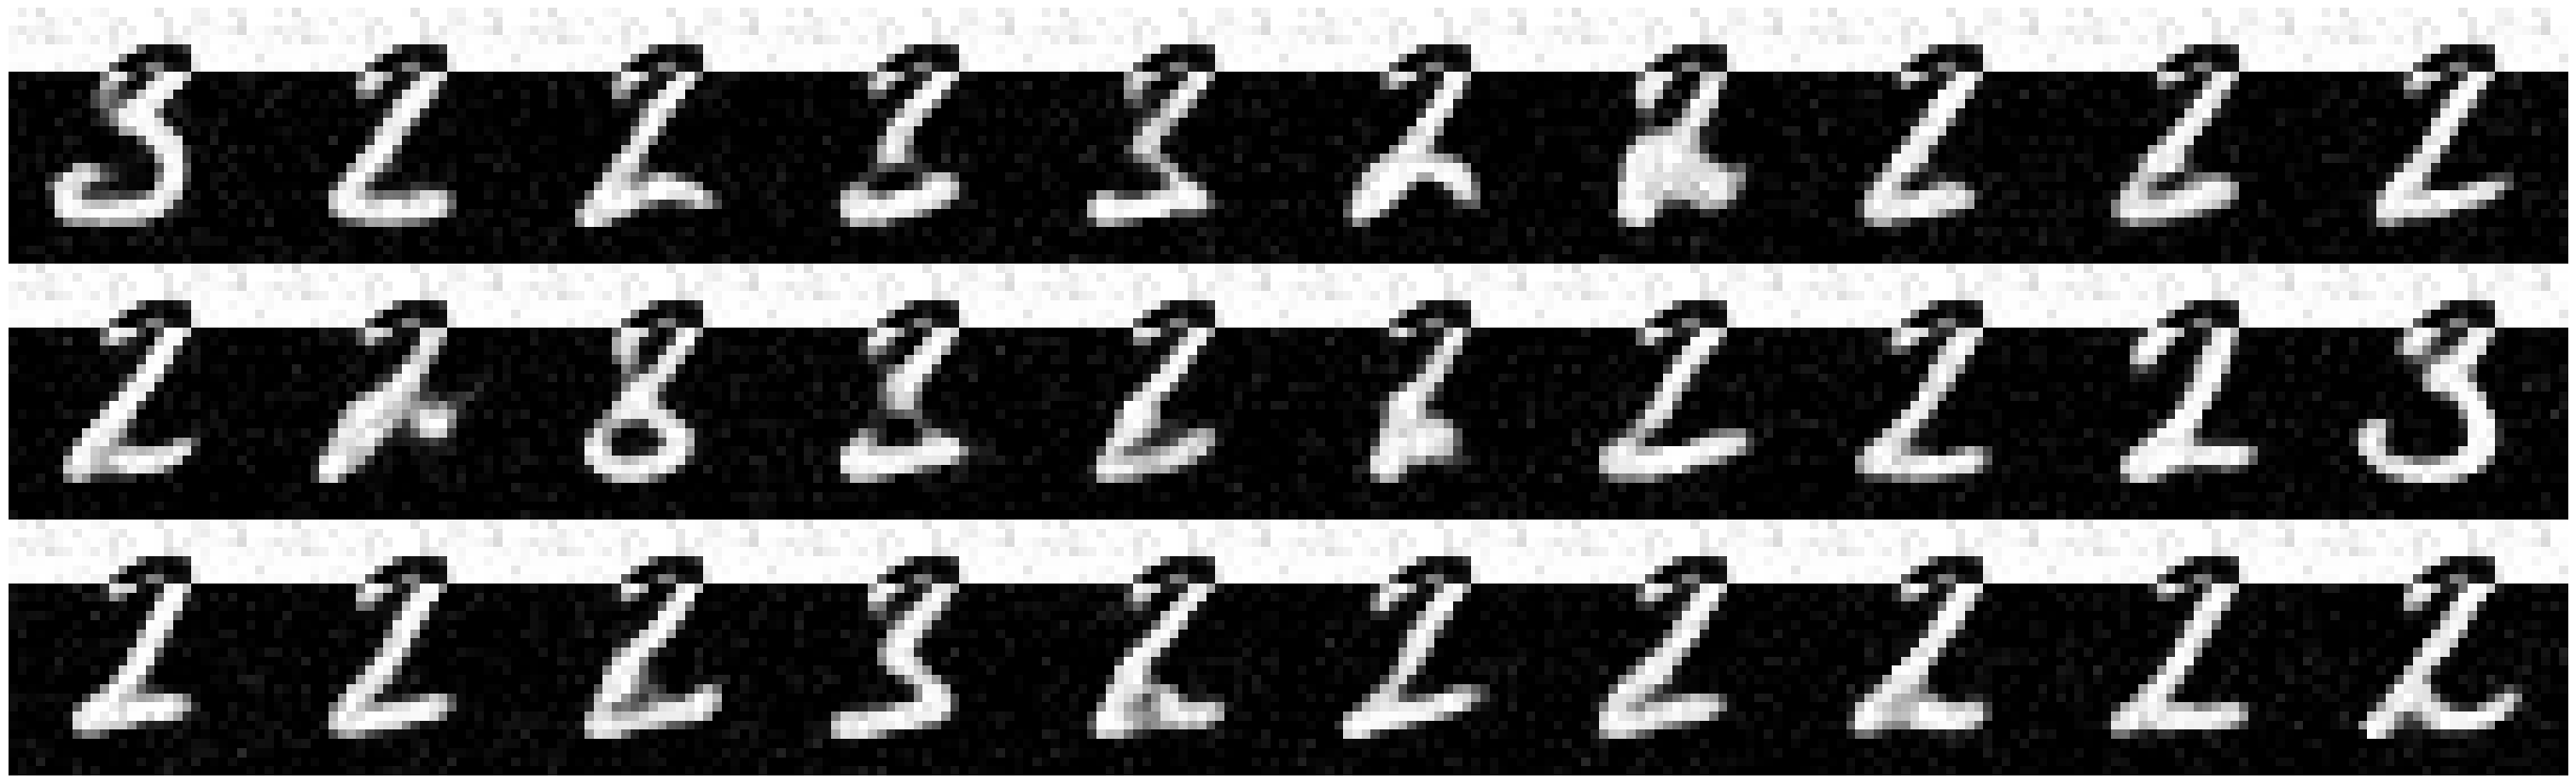

In [17]:
for r in range(n_run):
    try:
        logger.info('Starting run {0}...'.format(r+1))
        start_time = timer()
        h_samples, mom_samples, accept = hier_hmc_sampler.get_samples(
            pos=u_init * 1., dt=dt,  n_step_per_sample=n_step_per_sample, 
            n_sample=n_sample + n_warm_up)
        run_time = timer() - start_time
        logger.info('...completed, accepted: {0}, run time: {1:.1f}s'
                    .format(accept, run_time))
        x_samples = generator(np.c_[
                h_samples, 
                rng.normal(size=(h_samples.shape[0], consts['n_pixel']))
        ])
        x_samples[:, consts['observed_slice']] = y_obs
        x_rev_samples = x_samples[n_warm_up::thin_factor] * 1.
        x_rev_samples[:, consts['observed_slice']] = (
            1. - x_rev_samples[:, consts['observed_slice']])
        print('Consecutive samples')
        fig, ax = plot_tiled_samples(x_samples[n_warm_up:], 40, (16, 16))
        plt.show()
        print('Samples thinned by factor {0}'.format(thin_factor))
        fig, ax = plot_tiled_samples(x_rev_samples, fig_size=(10, 3))
        ax.set_frame_on(False)
        fig.subplots_adjust(left=0, right=10., bottom=0, top=3.)
        fig.savefig(os.path.join(exp_dir, 'hmc-mnist-samples-{0}.png'.format(r+1)), 
                    bbox_inches='tight', pad_inches=0., dpi=28)
        plt.show()
        np.savez(
            os.path.join(exp_dir, 'hmc-hier-results-{0}.npz'.format(r+1)),
            h_samples=h_samples, accept=accept, run_time=run_time, 
            dt=dt, x_samples=x_samples
        )
    except Exception as e:
        logger.exception('Error encountered run {0}:'.format(r+1))